In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

In [2]:
from sklearn.metrics import f1_score

# Data loading

In [3]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [4]:
def read_dataset(filename, splitter="\t"):
    data = []
    sentence = []
    tags = []
    with open(filename) as f:
        for line in f:
            if not line.isspace():
                word, tag = line.split(splitter)
                sentence.append(word)
                tags.append(tag.strip())
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
    return data

In [5]:
training_data = read_dataset("data/train.tsv")

In [6]:
training_data[0]

(['also',
  ',',
  'i',
  'have',
  'recently',
  'discovered',
  'advil',
  'liquigels',
  'work',
  'much',
  'better',
  'and',
  'faster',
  'for',
  'a',
  'headache',
  'than',
  'regular',
  'ibuprofen',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Predicate',
  'O',
  'O',
  'B-Aspect',
  'O',
  'O',
  'B-Object',
  'O'])

In [7]:
# test_data = read_dataset("test_no_answers.tsv", splitter="\n")
test_data = read_dataset("data/test.tsv")

In [8]:
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
for sent, tags in test_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index


tag_to_ix = {
    "O": 0,
    "B-Object": 1,
    "I-Object": 2,
    "B-Aspect": 3,
    "I-Aspect": 4,
    "B-Predicate": 5,
    "I-Predicate": 6
}  # Assign each tag with a unique index

idx_to_tag = dict(map(reversed, tag_to_ix.items()))

EMBEDDING_DIM = 32
HIDDEN_DIM = 64

# Tagger

In [9]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

# Training

In [10]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [11]:
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

for epoch in tqdm(range(10)):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [07:59<00:00, 47.98s/it]


# Inference

In [12]:
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
    
    for i, y in zip(training_data[0][0], tags):
        print(i, y)

also O
, O
i O
have O
recently O
discovered O
advil B-Object
liquigels O
work O
much O
better B-Predicate
and O
faster B-Predicate
for O
a O
headache O
than O
regular O
ibuprofen B-Object
. O


In [13]:
with open("out_test.tsv", "w") as w:
    with torch.no_grad():
        for sentence in tqdm(test_data):
            inputs = prepare_sequence(sentence[0], word_to_ix)
            tag_scores = model(inputs)
            tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
            for i, y in zip(sentence[0], tags):
                w.write(f"{i}\t{y}\n")
            w.write("\n")
            

 13%|█▎        | 37/283 [00:00<00:00, 369.04it/s]

100%|██████████| 283/283 [00:00<00:00, 434.76it/s]


In [14]:
!zip out.zip out_test.tsv

updating: out_test.tsv (deflated 73%)


# Evaluation

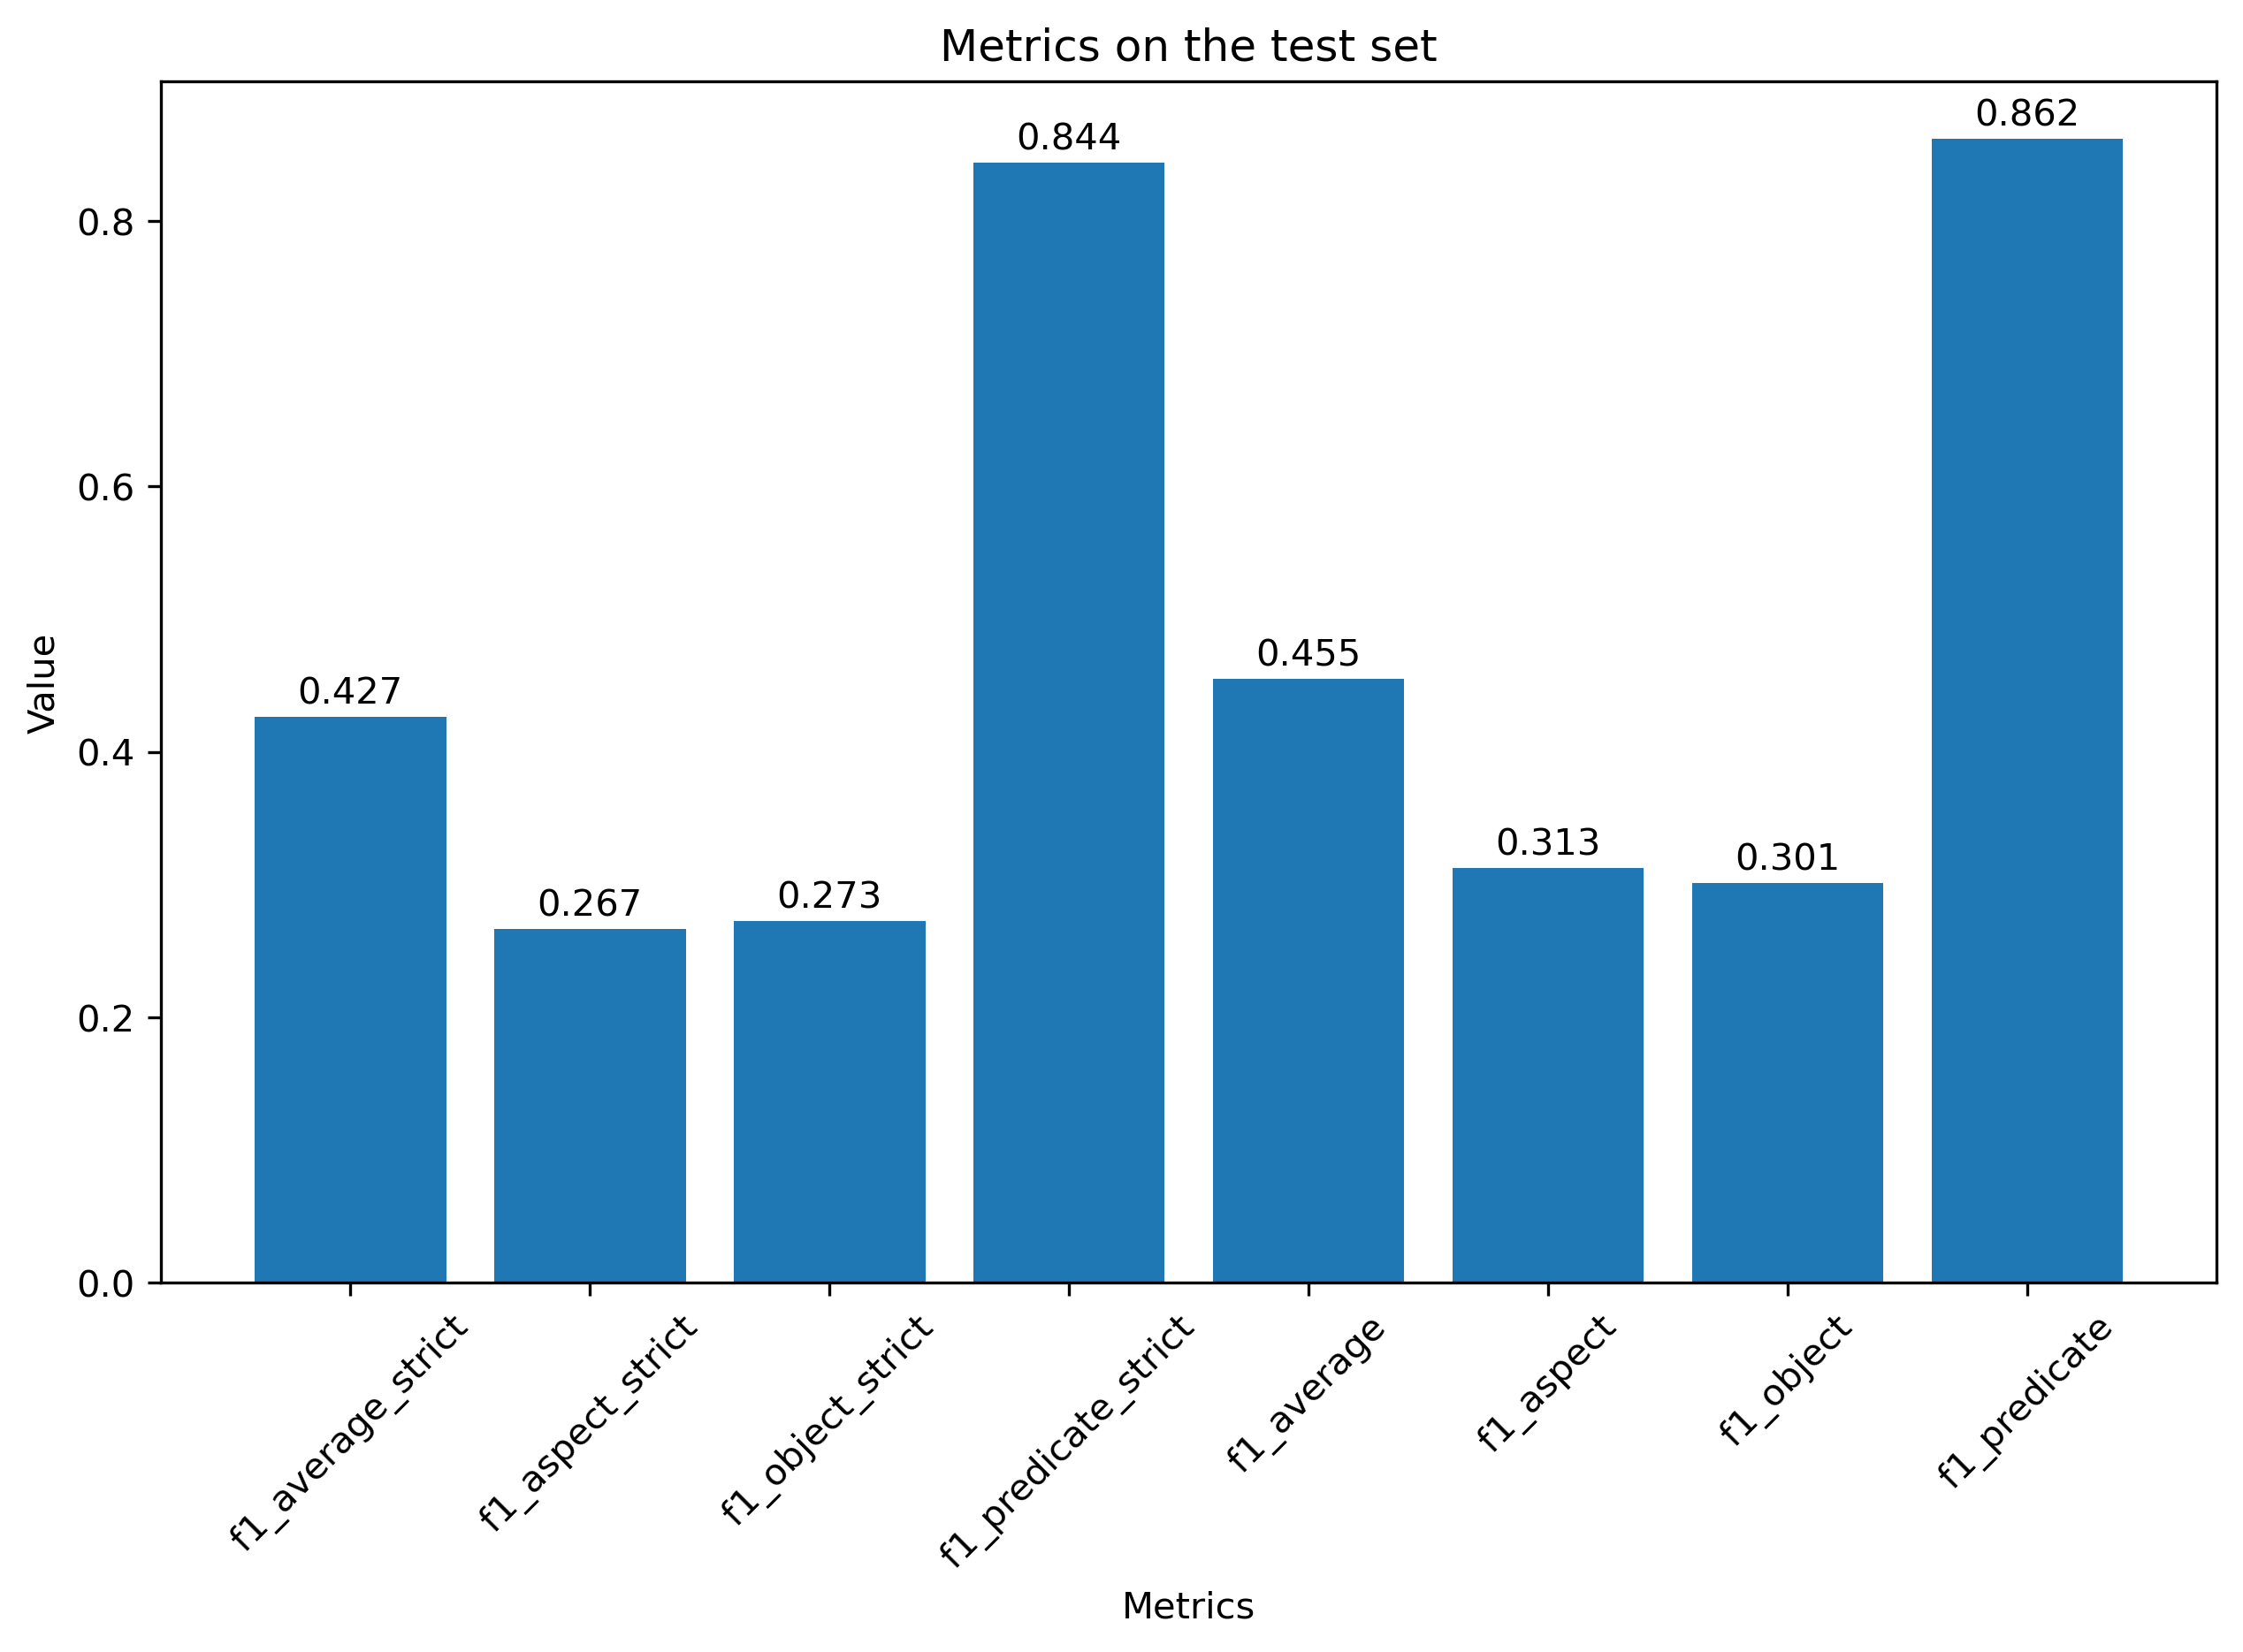

,metric,value
0,f1_average_strict,0.426630
1,f1_aspect_strict,0.266958
2,f1_object_strict,0.272727
3,f1_predicate_strict,0.844334
4,f1_average,0.455444
5,f1_aspect,0.312910
6,f1_object,0.301484
7,f1_predicate,0.861851


In [84]:
import evaluation.evaluate_f1_partial as efp
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

efp.main('data/test.tsv', 'out_test.tsv', 'metric.csv')

def visualize_result(path_to_res_file: str,sep: str = ':', display_df: bool = True) -> pd.DataFrame:
    """
    Visualize metrics from file.
    :param path_to_res_files: path to metric file with .csv extension;
    :param sep: csv separator;
    :return: dataframe with metrics.
    """
    df = pd.read_csv('metric.csv', sep=':', names=['metric', 'value'])

    plt.figure(figsize=(10, 6), dpi = 300)
    plt.bar(df['metric'], df['value'])
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Metrics on the test set')
    for i, value in enumerate(df['value']):
        plt.text(i, value + 0.01, str(round(value, 3)), ha='center')
    plt.xticks(rotation=45)
    plt.show()
    
    if display_df:
        display(df)
    return df

_ = visualize_result('metric.csv')